# Final Project - Group 2

## Irvandhi Stanly Winata, Lungun Simbolon, Reynaldi Evans, Taliida Nabilah
## Batch : HCK - 013

**Objective and Background**

This project is intended to create an ANN model to predict stock prices of the most popular banking companies in Indonesia using a sequential architecture with LSTM. Firstly, the data set will be cleaned and adjusted by the data engineer teaam through a datapipelnes in airflow. Then, the data analyst will create visualization and draw insights related to the dataset itself to determine the objective and scope of the project. Then, this notebook will consist of the neural network model construction for all different banking companies. We will firstly fetch the stock price data of the relevant companies from yfinance. Then, data will be splited into train and test set to avoid data leakage and the data will be scaled using MinMax scaler. Then, we define the X and y for the trainset and model architecture and train the model with MAPE as the measurement. After that, we predict the test set and compare it with the actual test data. And lastly, the model will be deployed via HuggingFace.

---

# Importing Necessary Libraries
Before we start the analysis, we have to import the necessary packages and libraries to assist our machine learning model creation.

In [13]:
import yfinance as yf
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import numpy as np
from tensorflow.keras.regularizers import L2
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

# BBCA.JK

## Data Loading

The dataset containing the information about the stock price was obtained through yfinance library. The timeframe of interest in this project will range from January 1st 20203 - March 31st 2024. The data was sucessfully loaded into this notebook. The first 10 rows of the dataset are shown below:

In [2]:
df = yf.Ticker("BBCA.JK").history(start = "2023-01-01", end = "2024-03-31")
df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-02 00:00:00+07:00,8178.573241,8202.417478,8107.040530,8154.729004,10653900,0.0,0.0
2023-01-03 00:00:00+07:00,8154.729004,8202.417478,8130.884767,8154.729004,27399100,0.0,0.0
2023-01-04 00:00:00+07:00,8130.884755,8178.573229,7963.975098,7963.975098,90918800,0.0,0.0
2023-01-05 00:00:00+07:00,7963.975092,7987.819329,7773.221197,7868.598145,128838500,0.0,0.0
2023-01-06 00:00:00+07:00,7725.532727,7940.130858,7725.532727,7916.286621,69286600,0.0,0.0
2023-01-09 00:00:00+07:00,7940.129904,8059.351074,7940.129904,8059.351074,86916900,0.0,0.0
2023-01-10 00:00:00+07:00,8011.663059,8035.507294,7773.220706,7797.064941,101759100,0.0,0.0
2023-01-11 00:00:00+07:00,7677.844727,7773.221680,7630.156250,7749.377441,96069100,0.0,0.0
2023-01-12 00:00:00+07:00,7773.220706,7892.441883,7749.376471,7797.064941,103804600,0.0,0.0


For the model prediction, the main interest would be the closing stock price. Thus, we need to create another dataframe consisting of only the close price and extract the value

In [3]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(297, 1)

We split the data intro train and test set

In [4]:
# 85% to Train , 15% to Test
train_size = int(len(data)*.85)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = data[ :train_size , 0:1 ]
test_data = data[ train_size-5: , 0:1 ]

Train Size : 252 Test Size : 45


## Scaling

The numerical features will be scaled using MinMaxScaler(). MinMaxScaler scales the data to a fixed range, usually between 0 and 1. This normalization is beneficial for ANNs, including LSTM networks, because it helps in stabilizing the training process. Neural networks tend to perform better when input features are on similar scales. For time series data, which may have varying ranges and magnitudes, normalization ensures that the model's learning isn't dominated by features with larger scales.

In [5]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_train = scaler.fit_transform(np.array(train_data).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data).reshape(-1, 1))

Making X_train and y_train for training

In [6]:
# create dataset with 60 time steps and (59 input and only 1 output in each ) as this is a regression problem
X_train = []
y_train = []

for i in range(60, len(scaled_train)):
    X_train.append(scaled_train[i-5: i,0 ])
    y_train.append(scaled_train[i, 0])
    
# convert Xs, y to arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape data -->> Xs = (rows, timestep, [n_cols = 2]), y = (rows,   )
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape, y_train.shape

((192, 5, 1), (192,))

## Sequential Model Creation And Training

A Sequential model in deep learning, particularly in frameworks like Keras, refers to a type of neural network architecture where layers are stacked sequentially, one on top of the other. It's a linear stack of layers where the output of each layer serves as the input to the next layer. This architecture is well-suited for feedforward neural networks, where information flows in one direction, from the input layer through hidden layers to the output layer.

LSTM networks are favored for time series data due to their ability to effectively capture long-term dependencies. Traditional RNNs struggle with this due to the vanishing gradient problem. LSTMs mitigate this issue with memory cells and gating mechanisms, enabling them to retain and selectively forget information over long sequences. Additionally, LSTMs can handle sequences of varying lengths, adapt to noisy and irregular data, and efficiently learn hierarchical representations. Their stateful memory allows them to retain context across time steps, making them adept at tasks like sequence prediction and anomaly detection in time series data.

In [82]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()

# Define the model_bca
model_bca = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=64, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=L2(0.001))
])

model_bca.compile(optimizer='adam', loss='mape', metrics=['mape']) # Notice the change here

# Display model_bca summary
model_bca.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,049 (1.29 MB)

 Trainable params: 338,049 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Callbacks will monitor the  loss during training. If the loss does not improve for a certain number of epochs (specified by the patience parameter), training will stop early. Additionally, the learning rate will be reduced if the loss does not improve for another specified number of epochs.

In [83]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [84]:
history_bca = model_bca.fit(X_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 95.5050 - mape: 95.0119 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 48.3815 - mape: 47.9080 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22.9012 - mape: 22.4332 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.7808 - mape: 19.3182 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.0458 - mape: 15.5872 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.3014 - mape: 16.8476 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.5112 - mape: 15.0618 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.1287 - mape: 13.6840 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.9055 - mape: 14.4653 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.2267

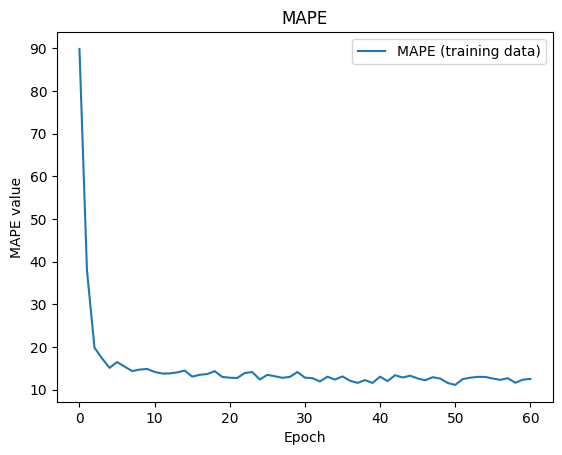

In [85]:
# Plot MAPE
plt.plot(history_bca.history['mape'], label='MAPE (training data)')
plt.title('MAPE')
plt.ylabel('MAPE value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

## Predicting The Test Set

In [7]:
# Creating a testing set with 60 time-steps and 1 output
X_test = []
y_test = []

for i in range(5, len(scaled_test)):
    X_test.append(scaled_test[i-5:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
X_test.shape

(45, 5, 1)

In [21]:
#inverse y_test scaling
predictions = model_bca.predict(X_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(45, 1)

## Predicting Train Set

In [45]:
#inverse y_test scaling
predictions_train = model_bca.predict(X_train)

#inverse predictions_train scaling
predictions_train = scaler.inverse_transform(predictions_train)
predictions_train.shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(192, 1)

## Model Analysis

In [44]:
# Inverse scaling of y_test
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_original, predictions)
print("Test MAPE after inverse scaling:", mape)

Test MAPE after inverse scaling: 0.029602848622221605


In [69]:
# Inverse scaling of y_train
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_train_original, predictions_train)
print("Train MAPE after inverse scaling:", mape)

Train MAPE after inverse scaling: 0.01501739392081044


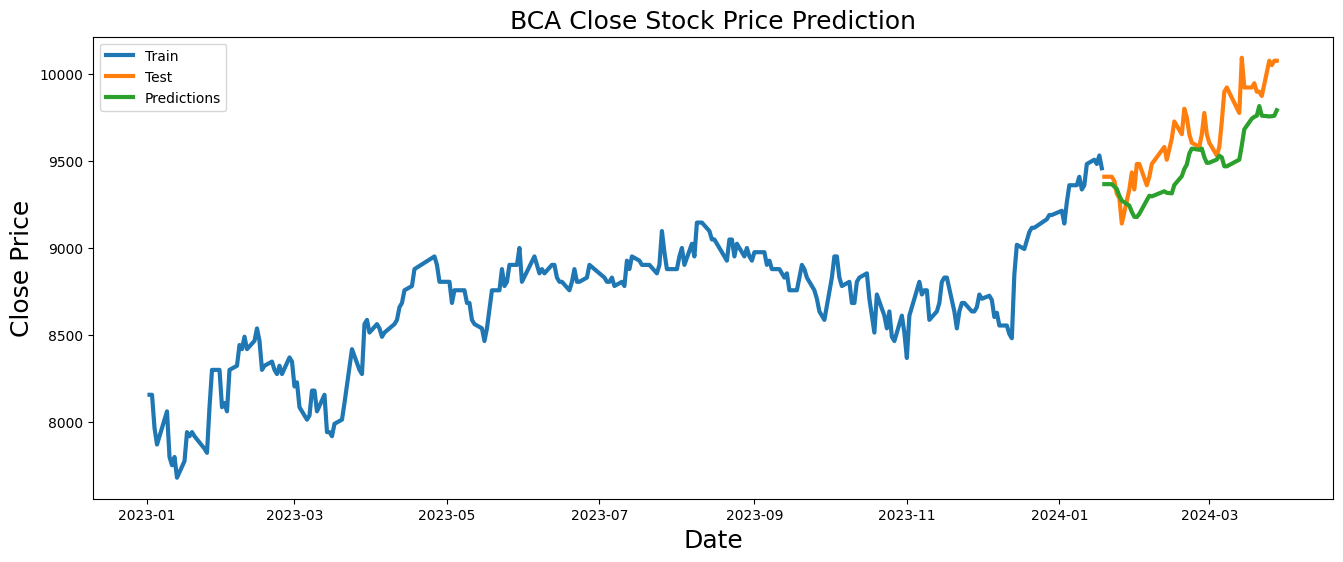

In [17]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('BCA Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

## Model Saving

In [91]:
model_bca.save("model_bca.keras")

# BBRI.JK

## Data Loading

The dataset containing the information about the stock price was obtained through yfinance library. The timeframe of interest in this project will range from January 1st 20203 - March 31st 2024. The data was sucessfully loaded into this notebook. The first 10 rows of the dataset are shown below:

In [58]:
df = yf.Ticker("BBRI.JK").history(start = "2023-01-01", end = "2024-03-31")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-02 00:00:00+07:00,4385.260291,4394.191575,4304.878738,4349.535156,100200100,0.0,0.0
2023-01-03 00:00:00+07:00,4313.810283,4376.329273,4313.810283,4331.672852,95136500,0.0,0.0
2023-01-04 00:00:00+07:00,4331.672931,4331.672931,4260.222656,4260.222656,188071000,0.0,0.0
2023-01-05 00:00:00+07:00,4242.359845,4251.291129,4081.596735,4144.115723,292142000,0.0,0.0
2023-01-06 00:00:00+07:00,4063.734427,4144.115987,4063.734427,4126.253418,175932000,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-22 00:00:00+07:00,6050.000000,6125.000000,6050.000000,6125.000000,46529200,0.0,0.0
2024-03-25 00:00:00+07:00,6250.000000,6250.000000,6125.000000,6250.000000,115729600,0.0,0.0
2024-03-26 00:00:00+07:00,6300.000000,6300.000000,6200.000000,6300.000000,120748400,0.0,0.0


For the model prediction, the main interest would be the closing stock price. Thus, we need to create another dataframe consisting of only the close price and extract the value

In [59]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(297, 1)

We split the data intro train and test set

In [60]:
# 85% to Train , 15% to Test
train_size = int(len(data)*.85)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = data[ :train_size , 0:1 ]
test_data = data[ train_size-5: , 0:1 ]

Train Size : 252 Test Size : 45


## Scaling

The numerical features will be scaled using MinMaxScaler(). MinMaxScaler scales the data to a fixed range, usually between 0 and 1. This normalization is beneficial for ANNs, including LSTM networks, because it helps in stabilizing the training process. Neural networks tend to perform better when input features are on similar scales. For time series data, which may have varying ranges and magnitudes, normalization ensures that the model's learning isn't dominated by features with larger scales.

In [61]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_train = scaler.fit_transform(np.array(train_data).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data).reshape(-1, 1))

Making X_train and y_train for training

In [62]:
# create dataset with 60 time steps and (59 input and only 1 output in each ) as this is a regression problem
X_train = []
y_train = []

for i in range(60, len(scaled_train)):
    X_train.append(scaled_train[i-5: i,0 ])
    y_train.append(scaled_train[i, 0])
    
# convert Xs, y to arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape data -->> Xs = (rows, timestep, [n_cols = 2]), y = (rows,   )
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape, y_train.shape

((192, 5, 1), (192,))

## Sequential Model Creation And Training

A Sequential model in deep learning, particularly in frameworks like Keras, refers to a type of neural network architecture where layers are stacked sequentially, one on top of the other. It's a linear stack of layers where the output of each layer serves as the input to the next layer. This architecture is well-suited for feedforward neural networks, where information flows in one direction, from the input layer through hidden layers to the output layer.

LSTM networks are favored for time series data due to their ability to effectively capture long-term dependencies. Traditional RNNs struggle with this due to the vanishing gradient problem. LSTMs mitigate this issue with memory cells and gating mechanisms, enabling them to retain and selectively forget information over long sequences. Additionally, LSTMs can handle sequences of varying lengths, adapt to noisy and irregular data, and efficiently learn hierarchical representations. Their stateful memory allows them to retain context across time steps, making them adept at tasks like sequence prediction and anomaly detection in time series data.

In [103]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()

# Define the model_bri
model_bri = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=64, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=L2(0.001))
])

model_bri.compile(optimizer='adam', loss='mape', metrics=['mape']) # Notice the change here

# Display model_bri summary
model_bri.summary()


c:\Users\Irvandhi\miniconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,049 (1.29 MB)

 Trainable params: 338,049 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Callbacks will monitor the  loss during training. If the loss does not improve for a certain number of epochs (specified by the patience parameter), training will stop early. Additionally, the learning rate will be reduced if the loss does not improve for another specified number of epochs.

In [104]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [105]:
history_bri = model_bri.fit(X_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 91.9980 - mape: 91.5081 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36.9542 - mape: 36.4830 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.3786 - mape: 18.9132 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.3297 - mape: 19.8691 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.4470 - mape: 19.9900 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.6747 - mape: 17.2226 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.9103 - mape: 14.4622 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.1899 - mape: 14.7463 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.4026 - mape: 13.9632 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.9422

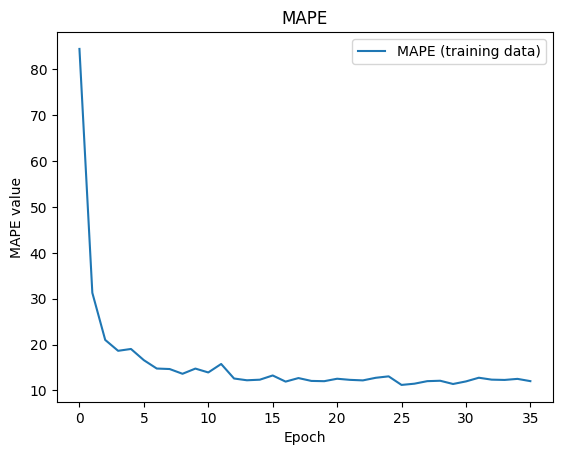

In [107]:
# Plot MAPE
plt.plot(history_bri.history['mape'], label='MAPE (training data)')
plt.title('MAPE')
plt.ylabel('MAPE value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

## Predicting The Test Set

In [63]:
# Creating a testing set with 60 time-steps and 1 output
X_test = []
y_test = []

for i in range(5, len(scaled_test)):
    X_test.append(scaled_test[i-5:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [64]:
X_test.shape

(45, 5, 1)

In [65]:
#inverse y_test scaling
predictions = model_bri.predict(X_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


(45, 1)

## Predicting Train Set

In [66]:
#inverse y_test scaling
predictions_train = model_bri.predict(X_train)

#inverse predictions_train scaling
predictions_train = scaler.inverse_transform(predictions_train)
predictions_train.shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(192, 1)

## Model Analysis

In [67]:
# Inverse scaling of y_test
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_original, predictions)
print("Test MAPE after inverse scaling:", mape)

Test MAPE after inverse scaling: 0.022232522482005735


In [70]:
# Inverse scaling of y_train
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_train_original, predictions_train)
print("Train MAPE after inverse scaling:", mape)

Train MAPE after inverse scaling: 0.01501739392081044


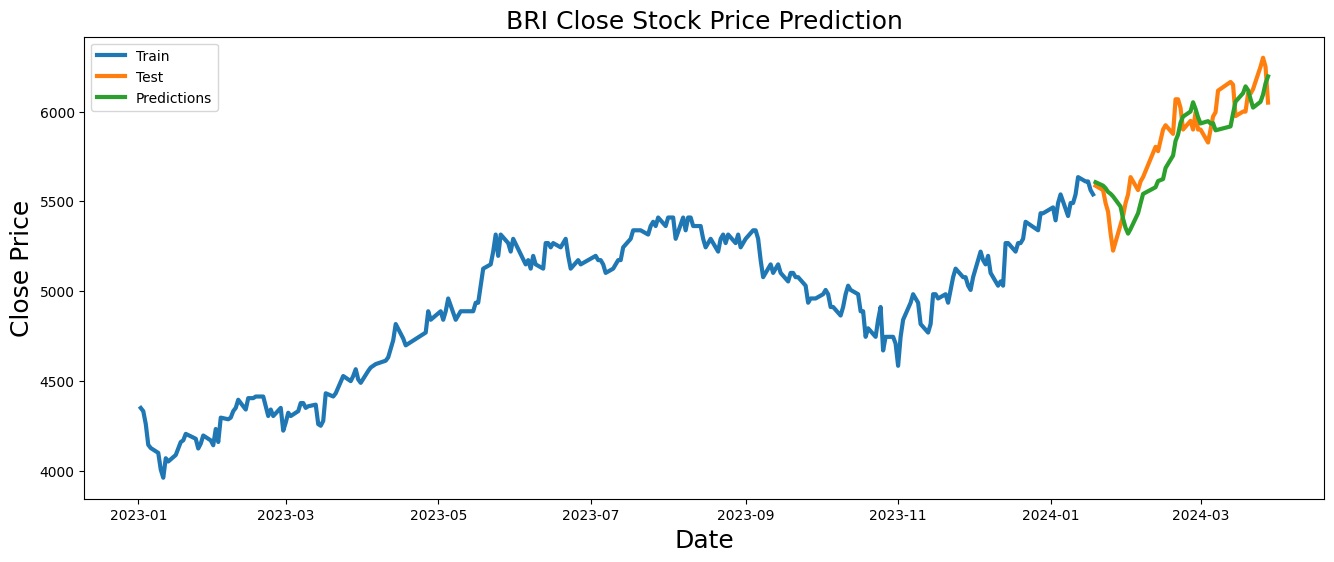

In [113]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('BRI Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

## Model Saving

In [114]:
model_bri.save("model_bri.keras")

# BMRI.JK

## Data Loading

The dataset containing the information about the stock price was obtained through yfinance library. The timeframe of interest in this project will range from January 1st 20203 - March 31st 2024. The data was sucessfully loaded into this notebook. The first 10 rows of the dataset are shown below:

In [71]:
df = yf.Ticker("BMRI.JK").history(start = "2023-01-01", end = "2024-03-31")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-02 00:00:00+07:00,4491.785871,4514.414515,4469.157227,4469.157227,5985400,0.0,0.0
2023-01-03 00:00:00+07:00,4457.843294,4514.414909,4457.843294,4503.100586,13815200,0.0,0.0
2023-01-04 00:00:00+07:00,4537.043457,4559.672103,4514.414811,4537.043457,38575800,0.0,0.0
2023-01-05 00:00:00+07:00,4548.357713,4548.357713,4401.271518,4446.528809,84945800,0.0,0.0
2023-01-06 00:00:00+07:00,4401.271873,4435.214844,4344.700255,4435.214844,44097000,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-22 00:00:00+07:00,7000.000000,7075.000000,6950.000000,7050.000000,65219900,0.0,0.0
2024-03-25 00:00:00+07:00,7250.000000,7250.000000,7000.000000,7250.000000,78212700,0.0,0.0
2024-03-26 00:00:00+07:00,7225.000000,7225.000000,7125.000000,7175.000000,74274300,0.0,0.0


For the model prediction, the main interest would be the closing stock price. Thus, we need to create another dataframe consisting of only the close price and extract the value

In [72]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(297, 1)

We split the data intro train and test set

In [73]:
# 85% to Train , 15% to Test
train_size = int(len(data)*.85)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = data[ :train_size , 0:1 ]
test_data = data[ train_size-5: , 0:1 ]

Train Size : 252 Test Size : 45


## Scaling

The numerical features will be scaled using MinMaxScaler(). MinMaxScaler scales the data to a fixed range, usually between 0 and 1. This normalization is beneficial for ANNs, including LSTM networks, because it helps in stabilizing the training process. Neural networks tend to perform better when input features are on similar scales. For time series data, which may have varying ranges and magnitudes, normalization ensures that the model's learning isn't dominated by features with larger scales.

In [74]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_train = scaler.fit_transform(np.array(train_data).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data).reshape(-1, 1))

Making X_train and y_train for training

In [75]:
# create dataset with 60 time steps and (59 input and only 1 output in each ) as this is a regression problem
X_train = []
y_train = []

for i in range(60, len(scaled_train)):
    X_train.append(scaled_train[i-5: i,0 ])
    y_train.append(scaled_train[i, 0])
    
# convert Xs, y to arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape data -->> Xs = (rows, timestep, [n_cols = 2]), y = (rows,   )
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape, y_train.shape

((192, 5, 1), (192,))

## Sequential Model Creation And Training

A Sequential model in deep learning, particularly in frameworks like Keras, refers to a type of neural network architecture where layers are stacked sequentially, one on top of the other. It's a linear stack of layers where the output of each layer serves as the input to the next layer. This architecture is well-suited for feedforward neural networks, where information flows in one direction, from the input layer through hidden layers to the output layer.

LSTM networks are favored for time series data due to their ability to effectively capture long-term dependencies. Traditional RNNs struggle with this due to the vanishing gradient problem. LSTMs mitigate this issue with memory cells and gating mechanisms, enabling them to retain and selectively forget information over long sequences. Additionally, LSTMs can handle sequences of varying lengths, adapt to noisy and irregular data, and efficiently learn hierarchical representations. Their stateful memory allows them to retain context across time steps, making them adept at tasks like sequence prediction and anomaly detection in time series data.

In [122]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()

# Define the model_mri
model_mri = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=64, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=L2(0.001))
])

model_mri.compile(optimizer='adam', loss='mape', metrics=['mape']) # Notice the change here

# Display model_mri summary
model_mri.summary()


c:\Users\Irvandhi\miniconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,049 (1.29 MB)

 Trainable params: 338,049 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Callbacks will monitor the  loss during training. If the loss does not improve for a certain number of epochs (specified by the patience parameter), training will stop early. Additionally, the learning rate will be reduced if the loss does not improve for another specified number of epochs.

In [123]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [124]:
history_mri = model_mri.fit(X_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 92.6335 - mape: 92.1413 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 39.0073 - mape: 38.5331 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25.0442 - mape: 24.5758 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 22.8767 - mape: 22.4136 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 24.2578 - mape: 23.7984 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.3777 - mape: 18.9232 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.3855 - mape: 15.9348 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.8483 - mape: 16.4016 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.0534 - mape: 15.6102 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13.7

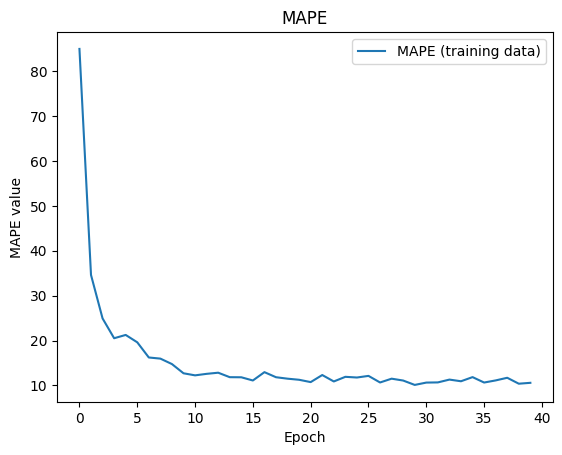

In [125]:
# Plot MAPE
plt.plot(history_mri.history['mape'], label='MAPE (training data)')
plt.title('MAPE')
plt.ylabel('MAPE value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

## Predicting The Test Set

In [91]:
# Creating a testing set with 60 time-steps and 1 output
X_test = []
y_test = []

for i in range(5, len(scaled_test)):
    X_test.append(scaled_test[i-5:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [92]:
X_test.shape

(45, 5, 1)

In [93]:
#inverse y_test scaling
predictions = model_mri.predict(X_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step


(45, 1)

## Predicting Train Set

In [94]:
#inverse y_test scaling
predictions_train = model_mri.predict(X_train)

#inverse predictions_train scaling
predictions_train = scaler.inverse_transform(predictions_train)
predictions_train.shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(192, 1)

## Model Analysis

In [95]:
# Inverse scaling of y_test
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_original, predictions)
print("Test MAPE after inverse scaling:", mape)

Test MAPE after inverse scaling: 0.017327203547215994


In [96]:
# Inverse scaling of y_train
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_train_original, predictions_train)
print("Train MAPE after inverse scaling:", mape)

Train MAPE after inverse scaling: 0.015335744295138435


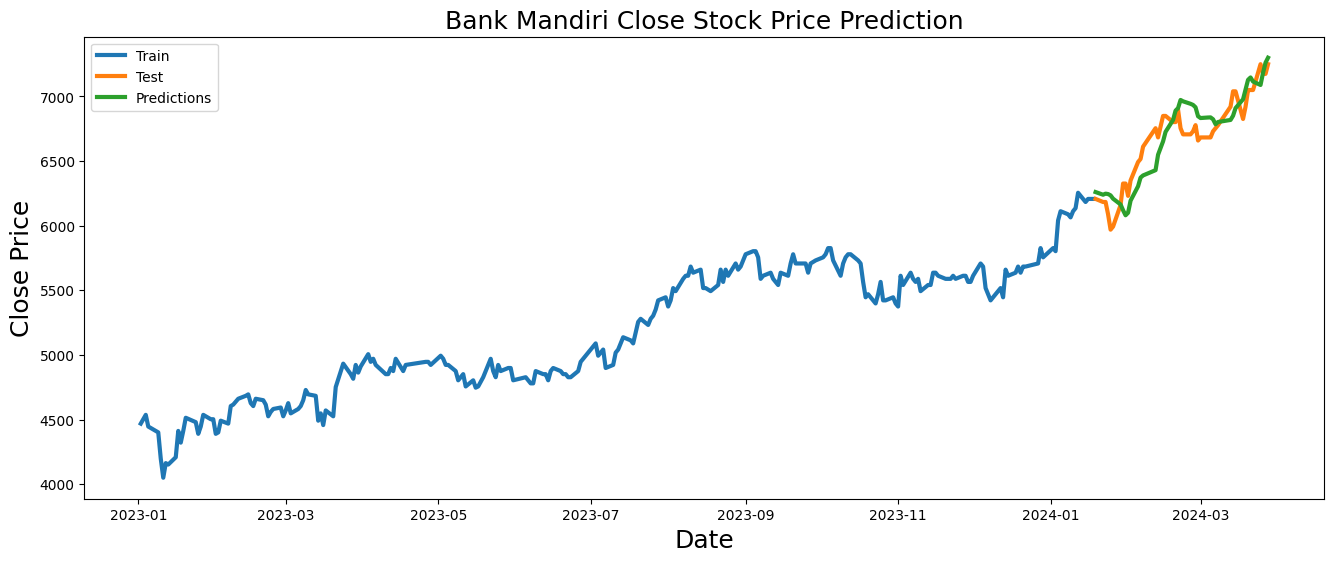

In [130]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Bank Mandiri Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

## Model Saving

In [131]:
model_mri.save("model_mri.keras")

# BBNI.JK

## Data Loading

The dataset containing the information about the stock price was obtained through yfinance library. The timeframe of interest in this project will range from January 1st 20203 - March 31st 2024. The data was sucessfully loaded into this notebook. The first 10 rows of the dataset are shown below:

In [85]:
df = yf.Ticker("BBNI.JK").history(start = "2023-01-01", end = "2024-03-31")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-02 00:00:00+07:00,4220.121094,4220.121094,4162.937881,4220.121094,13398400,0.0,0.0
2023-01-03 00:00:00+07:00,4208.684699,4254.431272,4185.811413,4242.994629,26463000,0.0,0.0
2023-01-04 00:00:00+07:00,4242.994620,4254.431263,4185.811404,4197.248047,48118400,0.0,0.0
2023-01-05 00:00:00+07:00,4185.811263,4185.811263,4037.134907,4117.191406,91135000,0.0,0.0
2023-01-06 00:00:00+07:00,4105.754506,4140.064433,4060.007938,4071.444580,47075000,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-22 00:00:00+07:00,5850.000000,5875.000000,5800.000000,5850.000000,29927600,0.0,0.0
2024-03-25 00:00:00+07:00,5925.000000,5925.000000,5825.000000,5925.000000,43514000,0.0,0.0
2024-03-26 00:00:00+07:00,5950.000000,5950.000000,5850.000000,5950.000000,29383900,0.0,0.0


For the model prediction, the main interest would be the closing stock price. Thus, we need to create another dataframe consisting of only the close price and extract the value

In [86]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(297, 1)

We split the data intro train and test set

In [87]:
# 85% to Train , 15% to Test
train_size = int(len(data)*.85)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = data[ :train_size , 0:1 ]
test_data = data[ train_size-5: , 0:1 ]

Train Size : 252 Test Size : 45


## Scaling

The numerical features will be scaled using MinMaxScaler(). MinMaxScaler scales the data to a fixed range, usually between 0 and 1. This normalization is beneficial for ANNs, including LSTM networks, because it helps in stabilizing the training process. Neural networks tend to perform better when input features are on similar scales. For time series data, which may have varying ranges and magnitudes, normalization ensures that the model's learning isn't dominated by features with larger scales.

In [88]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_train = scaler.fit_transform(np.array(train_data).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data).reshape(-1, 1))

Making X_train and y_train for training

In [89]:
# create dataset with 60 time steps and (59 input and only 1 output in each ) as this is a regression problem
X_train = []
y_train = []

for i in range(60, len(scaled_train)):
    X_train.append(scaled_train[i-5: i,0 ])
    y_train.append(scaled_train[i, 0])
    
# convert Xs, y to arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape data -->> Xs = (rows, timestep, [n_cols = 2]), y = (rows,   )
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape, y_train.shape

((192, 5, 1), (192,))

## Sequential Model Creation And Training

A Sequential model in deep learning, particularly in frameworks like Keras, refers to a type of neural network architecture where layers are stacked sequentially, one on top of the other. It's a linear stack of layers where the output of each layer serves as the input to the next layer. This architecture is well-suited for feedforward neural networks, where information flows in one direction, from the input layer through hidden layers to the output layer.

LSTM networks are favored for time series data due to their ability to effectively capture long-term dependencies. Traditional RNNs struggle with this due to the vanishing gradient problem. LSTMs mitigate this issue with memory cells and gating mechanisms, enabling them to retain and selectively forget information over long sequences. Additionally, LSTMs can handle sequences of varying lengths, adapt to noisy and irregular data, and efficiently learn hierarchical representations. Their stateful memory allows them to retain context across time steps, making them adept at tasks like sequence prediction and anomaly detection in time series data.

In [157]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()

# Define the model_bni
model_bni = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=64, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=L2(0.001))
])

model_bni.compile(optimizer='adam', loss='mape', metrics=['mape']) # Notice the change here

# Display model_bni summary
model_bni.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,049 (1.29 MB)

 Trainable params: 338,049 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [158]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [159]:
history_bni = model_bni.fit(X_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 93.2022 - mape: 92.7133 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39.0511 - mape: 38.5857 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 29.6377 - mape: 29.1798 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 27.6410 - mape: 27.1894 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 23.3501 - mape: 22.9025 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.1009 - mape: 18.6570 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.8491 - mape: 20.4073 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.2533 - mape: 16.8145 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.1332 - mape: 17.6988 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.9560 

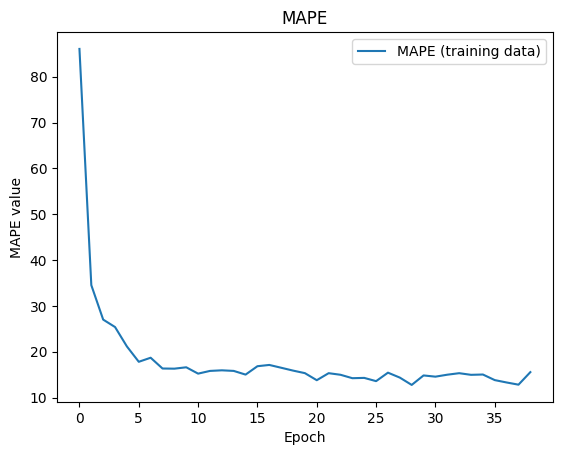

In [160]:
# Plot MAPE
plt.plot(history_bni.history['mape'], label='MAPE (training data)')
plt.title('MAPE')
plt.ylabel('MAPE value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

## Predicting The Test Set

In [98]:
# Creating a testing set with 60 time-steps and 1 output
X_test = []
y_test = []

for i in range(5, len(scaled_test)):
    X_test.append(scaled_test[i-5:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [99]:
X_test.shape

(45, 5, 1)

In [101]:
#inverse y_test scaling
predictions = model_bni.predict(X_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


(45, 1)

## Predicting Train Set

In [102]:
#inverse y_test scaling
predictions_train = model_bni.predict(X_train)

#inverse predictions_train scaling
predictions_train = scaler.inverse_transform(predictions_train)
predictions_train.shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(192, 1)

## Model Analysis

In [103]:
# Inverse scaling of y_test
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_original, predictions)
print("Test MAPE after inverse scaling:", mape)

Test MAPE after inverse scaling: 0.02749917484070902


In [104]:
# Inverse scaling of y_train
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_train_original, predictions_train)
print("Train MAPE after inverse scaling:", mape)

Train MAPE after inverse scaling: 0.015943670163688983


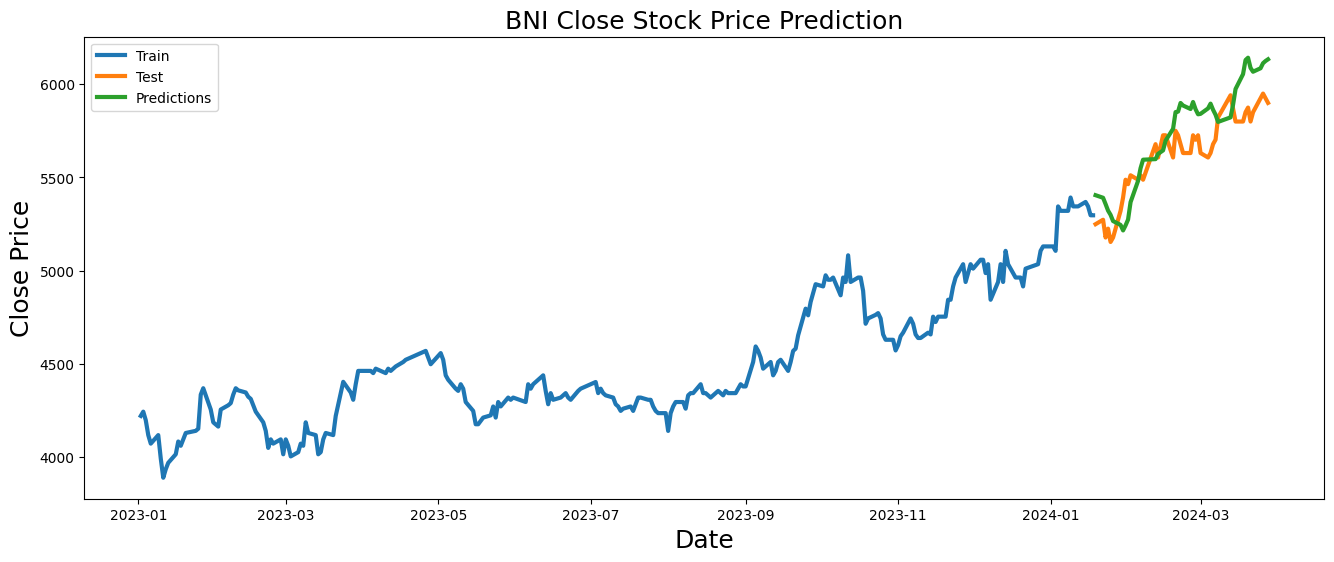

In [165]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('BNI Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

## Model Saving

In [166]:
model_bni.save("model_bni.keras")

# BRIS.JK

## Data Loading

The dataset containing the information about the stock price was obtained through yfinance library. The timeframe of interest in this project will range from January 1st 20203 - March 31st 2024. The data was sucessfully loaded into this notebook. The first 10 rows of the dataset are shown below:

In [106]:
df = yf.Ticker("BRIS.JK").history(start = "2023-01-01", end = "2024-03-31")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-02 00:00:00+07:00,1293.100073,1298.073535,1258.285840,1278.179688,10661100,0.0,0.0
2023-01-03 00:00:00+07:00,1278.179667,1387.595825,1273.206205,1387.595825,69673900,0.0,0.0
2023-01-04 00:00:00+07:00,1382.622388,1417.436620,1377.648926,1377.648926,58214700,0.0,0.0
2023-01-05 00:00:00+07:00,1377.648925,1382.622387,1322.940845,1327.914307,35944100,0.0,0.0
2023-01-06 00:00:00+07:00,1322.940776,1407.489622,1312.993853,1382.622314,43879400,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-22 00:00:00+07:00,2680.000000,2680.000000,2620.000000,2630.000000,20727900,0.0,0.0
2024-03-25 00:00:00+07:00,2680.000000,2680.000000,2630.000000,2660.000000,26442400,0.0,0.0
2024-03-26 00:00:00+07:00,2680.000000,2680.000000,2630.000000,2680.000000,19794100,0.0,0.0


For the model prediction, the main interest would be the closing stock price. Thus, we need to create another dataframe consisting of only the close price and extract the value

In [107]:
#Extracting the "Close" column from the DataFrame
dataset = df["Close"]        
dataset = pd.DataFrame(dataset)

data = dataset.values
data.shape

(297, 1)

We split the data intro train and test set

In [108]:
# 85% to Train , 25% to Test
train_size = int(len(data)*.85)
test_size = len(data) - train_size 

print("Train Size :",train_size,"Test Size :",test_size)

train_data = data[ :train_size , 0:1 ]
test_data = data[ train_size-5: , 0:1 ]

Train Size : 252 Test Size : 45


## Scaling

The numerical features will be scaled using MinMaxScaler(). MinMaxScaler scales the data to a fixed range, usually between 0 and 1. This normalization is beneficial for ANNs, including LSTM networks, because it helps in stabilizing the training process. Neural networks tend to perform better when input features are on similar scales. For time series data, which may have varying ranges and magnitudes, normalization ensures that the model's learning isn't dominated by features with larger scales.

In [109]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_train = scaler.fit_transform(np.array(train_data).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data).reshape(-1, 1))

Creating X_train and y_tarin for data training 

In [110]:
# create dataset with 60 time steps and (59 input and only 1 output in each ) as this is a regression problem
X_train = []
y_train = []

for i in range(60, len(scaled_train)):
    X_train.append(scaled_train[i-5: i,0 ])
    y_train.append(scaled_train[i, 0])
    
# convert Xs, y to arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape data -->> Xs = (rows, timestep, [n_cols = 2]), y = (rows,   )
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape, y_train.shape

((192, 5, 1), (192,))

## Sequential Model Creation And Training

A Sequential model in deep learning, particularly in frameworks like Keras, refers to a type of neural network architecture where layers are stacked sequentially, one on top of the other. It's a linear stack of layers where the output of each layer serves as the input to the next layer. This architecture is well-suited for feedforward neural networks, where information flows in one direction, from the input layer through hidden layers to the output layer.

LSTM networks are favored for time series data due to their ability to effectively capture long-term dependencies. Traditional RNNs struggle with this due to the vanishing gradient problem. LSTMs mitigate this issue with memory cells and gating mechanisms, enabling them to retain and selectively forget information over long sequences. Additionally, LSTMs can handle sequences of varying lengths, adapt to noisy and irregular data, and efficiently learn hierarchical representations. Their stateful memory allows them to retain context across time steps, making them adept at tasks like sequence prediction and anomaly detection in time series data.

In [34]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()

# Define the model_bca
model_bsi = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=64, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=L2(0.001))
])

model_bsi.compile(optimizer='adam', loss='mape', metrics=['mape']) # Notice the change here

# Display model_bca summary
model_bsi.summary()

C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,049 (1.29 MB)

 Trainable params: 338,049 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [36]:
history_bsi = model_bsi.fit(X_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 91.2315 - mape: 90.7396 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 35.6223 - mape: 35.1492 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.9275 - mape: 20.4606 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.2118 - mape: 21.7502 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.7272 - mape: 20.2700 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.8112 - mape: 16.3595 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.2989 - mape: 16.8522 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16.7046 - mape: 16.2630 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.3116 - mape: 16.8748 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 

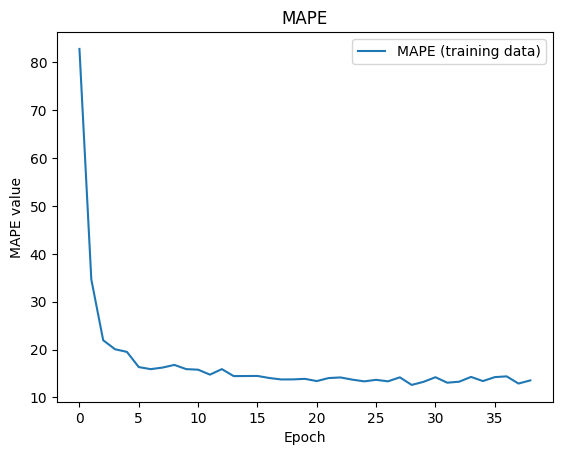

In [37]:
# Plot MAPE
plt.plot(history_bsi.history['mape'], label='MAPE (training data)')
plt.title('MAPE')
plt.ylabel('MAPE value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [105]:
model_bsi= tf.keras.models.load_model('model_bsi.keras')

## Predicting The Test Set

In [111]:
# Creating a testing set with 60 time-steps and 1 output
X_test = []
y_test = []

for i in range(5, len(scaled_test)):
    X_test.append(scaled_test[i-5:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [112]:
X_test.shape

(45, 5, 1)

In [113]:
#inverse y_test scaling
predictions = model_bsi.predict(X_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


(45, 1)

## Predicting Train Set

In [114]:
#inverse y_test scaling
predictions_train = model_bsi.predict(X_train)

#inverse predictions_train scaling
predictions_train = scaler.inverse_transform(predictions_train)
predictions_train.shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(192, 1)

## Model Analysis

In [115]:
# Inverse scaling of y_test
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_original, predictions)
print("Test MAPE after inverse scaling:", mape)

Test MAPE after inverse scaling: 0.06785204013736672


In [116]:
# Inverse scaling of y_train
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Calculate MAPE
mape = mean_absolute_percentage_error(y_train_original, predictions_train)
print("Train MAPE after inverse scaling:", mape)

Train MAPE after inverse scaling: 0.022294345291929692


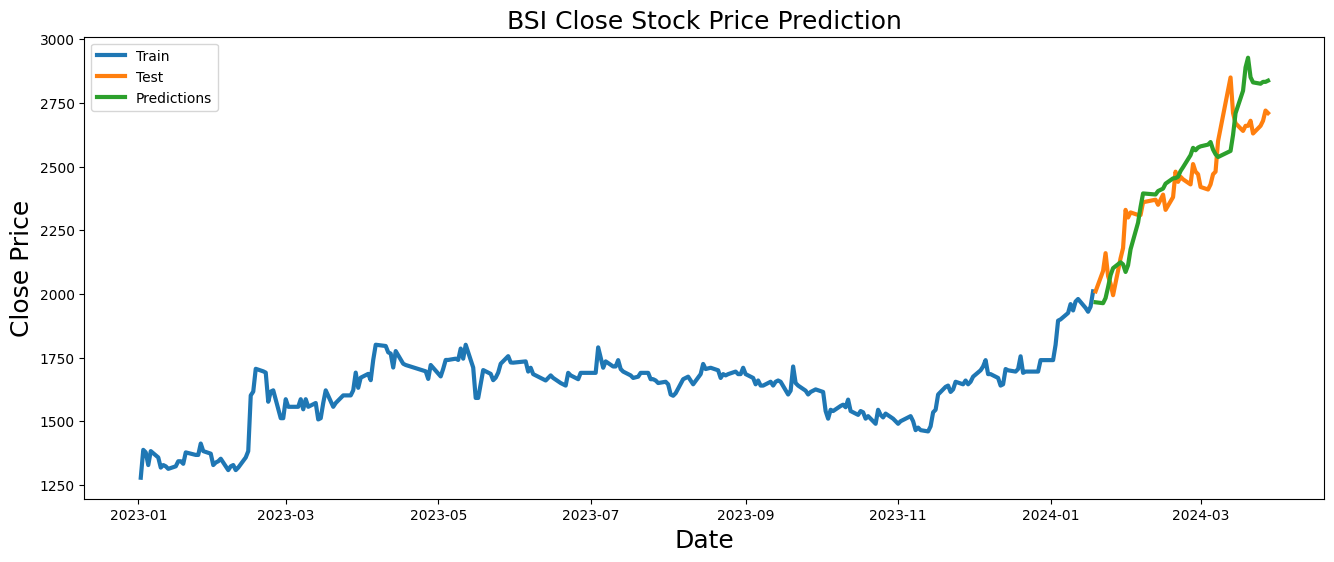

In [41]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('BSI Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

## Model Saving

In [42]:
model_bsi.save("model_bsi.keras")